In [1]:
import numpy as np
import mmh3
import os
import pandas as pd
import matplotlib.pyplot as plt

## Functions for minhash

In [2]:
def shingle(aString, q, delimiter=' '):
    """
    Input:
        - aString (str): string to split into shingles
        - q (int)
        - delimiter (str): string of the delimiter to consider to split the input string (default: space)
    Return: list of unique shingles
    """
    
    all_shingles = []
    if delimiter != '':
        words_list = str(aString).split(delimiter)
    else:
        words_list = aString
    if len(words_list) < q:
        q = len(words_list)
    for i in range (len(words_list)-q+1):
        all_shingles.append(delimiter.join(words_list[i:i+q]))
    return list(set(all_shingles))

def listhash(l,seed):
    val = 0
    for e in l:
        val = val ^ mmh3.hash(e, seed)
    return val 

def minhash(shingles_list, seed):
    """
    Input:
        - shingles_list (list of str): set of hashes
        - seed (int): seed for listhash function
    Return: minhash of given shingles
    """
    minhash_value = np.inf
    for aShingle in shingles_list:
        hashcode = listhash([aShingle], seed)
        if minhash_value == None or hashcode < minhash_value:
            minhash_value = hashcode
    return minhash_value

def minhash2(shingles_list, k):
    """
    Input:
        - shingles_list (list of str): set of hashes
        - k (int): seed for listhash function
    Return: sequence of k minhashes
    """
    all_minhash = []
    for i in range(k):
        all_minhash.append(minhash(shingles_list, i))
    return all_minhash

def signature(df_reviews, q = 3, num_hashes = 100):
    """
    Input:
        - dict_docs (dict of str:str): dictionary of {title:document}
        - q (int)
        - num_hashes (int)
    Return: dictionary consisting of document idâ€™s as keys and signatures as values
    """
    dict_signatures = {}
    total_texts = len(df_reviews.index)
    counter = 1
    for ix, text in enumerate(df_reviews['Clean_Review']):
        #print(f'{counter}/{total_texts} - {ix} - Processing...')
        doc_shingles = shingle(text, q)
        minhash_values = minhash2(doc_shingles, num_hashes)
        dict_signatures[ix] = minhash_values
        counter += 1
    return dict_signatures


## Import data

In [3]:
root = os.getcwd()
df = pd.read_csv(root + "\clean_sample_data.csv")

## Create minhash signatures for each review

In [4]:
k = 100
b,r = 10, 10
assert k == b*r

sigs = signature(df, q = 1, num_hashes = k)


## Clustering based on minhash signatures

In [5]:
def dic_to_vec(dic):
    """
    Create matrix of signatures usable by sklearn.
    
    args:
        dic: Dictionary of review signatures
    returns:
        numpy matrix of dimensions (# of reviews, # of minhashes)
    """
    for ix, sig in enumerate(list(dic.items())):
        if ix == 0:
            X = np.array([sig[1]])
        else:
            X = np.append(X,[sig[1]],axis=0)
    return X

In [6]:
X = dic_to_vec(sigs)

In [7]:
y = np.array(df.overall.values)

## KMeans clustering

In [8]:
from sklearn.cluster import KMeans

In [9]:
# Initialize classifier
k_means = KMeans(n_clusters=5, random_state=0)

In [10]:
X_transform = k_means.fit_transform(X,y)

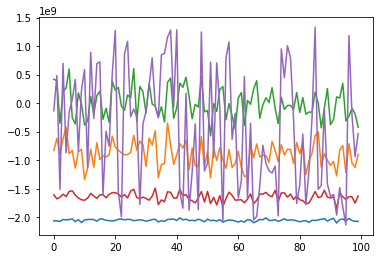

In [11]:
centroids = k_means.cluster_centers_

plt.plot(centroids.T)

In [12]:
def assign_cluster(centroid_list, dic):
    """
    Assigns each review to a cluster.
    
    Args:
        centroid_list: List of centroids in their vector format.
        dic: Dictionary of signatures of reviews.
    Returns:
        assignments: Dictionary of reviews and their cluster.
    """
    assignments = {}
    for ix, sig in enumerate(list(dic.items())):
        distances = []
        for j, centroid in enumerate(centroid_list):
            distances.append(np.linalg.norm(centroid-sig[1]))
        assignments[ix] = np.argmin(distances)
    return assignments

In [13]:
assigned = assign_cluster(centroids, sigs)

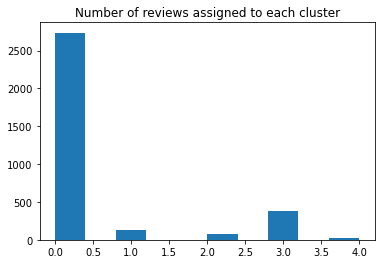

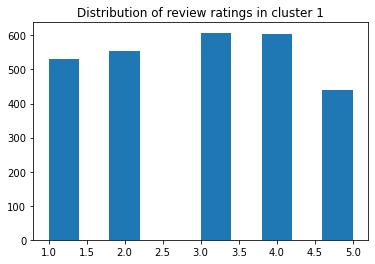

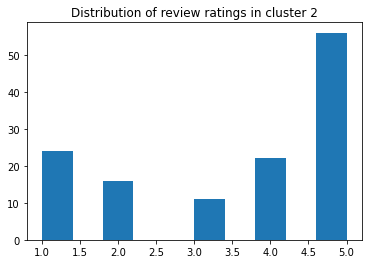

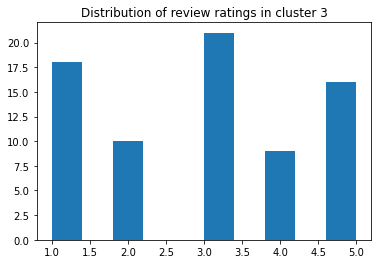

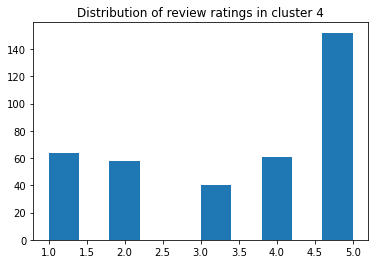

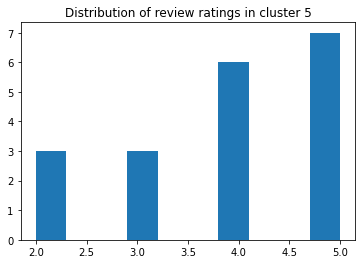

In [14]:
plt.hist(list(assigned.values()))
plt.title("Number of reviews assigned to each cluster")
plt.show()
for i in range(len(centroids)):
    df_slice = df.loc[pd.Series(list(assigned.values())) == i]
    #print(df_slice)
    #review_lengths = [len(df_slice.Clean_Review.values[i]) for i in range(len(df_slice.Clean_Review.values))]
    plt.hist(df_slice['overall'])
    plt.title(str("Distribution of review ratings in cluster "+ str(i+1)))
    plt.show()
    #plt.hist(review_lengths)
    #plt.show()

#### Subconclusion: Minhash vectorization does not result in meaningful clustering

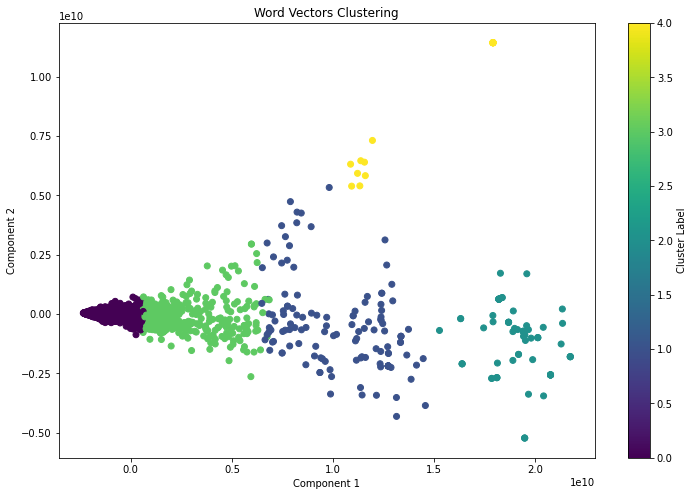

In [15]:
from sklearn.decomposition import PCA

labels = k_means.labels_

pca = PCA(n_components=4)
reduced_X = pca.fit_transform(X)
plt.figure(figsize=(12, 8))
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('Word Vectors Clustering')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


## Defining basic tf-idf function

In [16]:
from collections import Counter

def get_word_usage(documents, n_t = None, min_appearances = 1):
    """ Called by tf_idf.
    Get number of document appearances for all words: """ 
    document_appearances = {}
    
    N = len(documents)
    
    for i in range(N):
        text = str(documents[i]).split(" ")
        unique_words = np.unique(text)
        for word in unique_words:
            if not(n_t is None) and n_t[word] < min_appearances:
                # If the word does not appear in enough documents to
                # be significant for the cluster in general.
                continue
            elif word not in document_appearances.keys():
                document_appearances[word] = 1
            else:
                document_appearances[word] = document_appearances[word] + 1
    return document_appearances, N

def calc_tf_idf(documents, N, n_t):
    tf_idf_sparse = []
    for i in range(N):
        text = str(documents[i]).split(" ")
        word_freq = Counter(text)
        max_freq = max(word_freq.values())
        
        tf_idf_vector = np.zeros(len(n_t))
        
        for word in word_freq.items():
            if word[0] in n_t.keys():
                index = list(n_t).index(word[0])
                tf_idf_vector[index] = word[1]/max_freq*np.log2(N/n_t[word[0]])
        
        tf_idf_sparse.append(tf_idf_vector)
    
    return np.asarray(tf_idf_sparse)


def get_tf_idf(df_docs):
    documents = np.array(df_docs.Clean_Review.values)
    
    n_t, N = get_word_usage(documents)

    tf_idf_sparse_matrix = calc_tf_idf(documents, N, n_t)
    
    return tf_idf_sparse_matrix, np.asarray(list(n_t.keys()))


def find_n_largest_tfidf(tf_idf, features, n=5):
    largest_tfidf = []
    for values in tf_idf:
        print(values)
        sort_values = np.argsort(values)[-n:][::-1]
        significant_words = np.asarray(list(features.keys()))[sort_values]
        largest_tfidf.append(significant_words)
    return largest_tfidf

### Get TF-IDF values for all documents

In [17]:
#tf_idf, features = get_tf_idf(df)

## Class for tf-idf embedding

In [44]:
class TF_IDF_model:
    
    def __init__(self, min_appearances = 2, onehot = False):
        self.min_appearances = min_appearances
        self.onehot = onehot
    
    def get_word_usage(self, documents, n_t = None):
        """ Called by tf_idf.
        Get number of document appearances for all words: """ 
        document_appearances = {}

        N = len(documents)

        for i in range(N):
            text = str(documents[i]).split(" ")
            unique_words = np.unique(text)
            for word in unique_words:
                if not(n_t is None) and n_t[word] < self.min_appearances:
                    # If the word does not appear in enough documents to
                    # be significant for the cluster in general.
                    continue
                elif word not in document_appearances.keys():
                    document_appearances[word] = 1
                else:
                    document_appearances[word] = document_appearances[word] + 1
        return document_appearances, N

    def calc_tf_idf(self, documents, N, n_t):
        tf_idf_sparse = []
        for i in range(N):
            text = str(documents[i]).split(" ")
            word_freq = Counter(text)
            max_freq = max(word_freq.values())

            tf_idf_vector = np.zeros(len(n_t))

            for word in word_freq.items():
                if word[0] in n_t.keys():
                    index = list(n_t).index(word[0])
                    tf_idf_vector[index] = word[1]/max_freq*np.log2(N/n_t[word[0]])

            tf_idf_sparse.append(tf_idf_vector)

        return np.asarray(tf_idf_sparse)
    
    def merge_reviews(self, review_list, sentiment_list):
        """ Collect all text from reviews in each cluster into a single string """
        
        documents = []
        for i in self.uniq_sents:
            cluster_reviews = review_list[sentiment_list == i]
            all_text = str(cluster_reviews[0])
            for j in range(1, len(cluster_reviews)):
                all_text += " " + str(cluster_reviews[j])
            documents.append(all_text)

        return np.asarray(documents,str)


    def vectorize(self, reviews, sentiments):
        self.uniq_sents = np.unique(sentiments)
        
        documents = np.asarray(reviews)

        self.n_t_train, self.N_train = self.get_word_usage(documents)

        merged_documents = self.merge_reviews(documents, sentiments)

        n_t_cluster, N = self.get_word_usage(merged_documents, n_t = self.n_t_train)

        tf_idf_sparse_matrix_clusters = self.calc_tf_idf(merged_documents, N, n_t_cluster)

        # Feature selection: Remove all features without weight in any class.
        key_mask = np.asarray(list(n_t_cluster.keys()))[tf_idf_sparse_matrix_clusters.sum(axis=0) > 0]
        array_mask = [word[0] in key_mask for word in n_t_cluster.items()]

        n_t_cluster = dict(filter(lambda x: x[0] in key_mask, n_t_cluster.items()))
        tf_idf_sparse_matrix_clusters = tf_idf_sparse_matrix_clusters[:,array_mask]
        
        self.features = list(n_t_cluster.keys())
        self.sent_weights = tf_idf_sparse_matrix_clusters

        3#tf_idf_sparse_matrix = self.calc_tf_idf(documents, len(documents), n_t_cluster)

        #return tf_idf_sparse_matrix, tf_idf_sparse_matrix_clusters, n_t_cluster, n_t_reviews


    def find_n_largest_tfidf(self, tf_idf, n=5):
        largest_tfidf = []
        for values in tf_idf:
            sort_values = np.argsort(values)[-n:][::-1]
            significant_words = np.asarray(list(features.keys()))[sort_values]
            largest_tfidf.append(significant_words)
        return largest_tfidf

    def get_scores(self, reviews):
        N = len(reviews)
        tf_idf_sparse = []
        for i in range(N):
            text = str(reviews[i]).split(" ")
            word_freq = Counter(text)
            max_freq = max(word_freq.values())

            tf_idf_vector = np.zeros(len(self.features))

            for word in word_freq.items():                    
                if word[0] in self.features:
                    if self.onehot:
                        index = self.features.index(word[0])
                        tf_idf_vector[index] = 1
                    else:
                        index = self.features.index(word[0])
                        tf_idf_vector[index] = word[1]/max_freq*np.log2(self.N_train/self.n_t_train[word[0]])

            tf_idf_sparse.append(tf_idf_vector)
        
        tf_idf_sparse = np.asarray(tf_idf_sparse)
        
        scores = [ [tf_idf_sparse[i] @ self.sent_weights[j]*1000 for j in range(len(self.uniq_sents))] for i in range(tf_idf_sparse.shape[0]) ]
        
        return scores

## Supervised learning with tf_idf


In [59]:
df['Sentiment'] = df['overall'].copy()
df['Sentiment'].loc[(df['overall']<2.5)] = int(-1)
df['Sentiment'].loc[(df['overall']==3)] = int(0)
df['Sentiment'].loc[(df['overall']>3.5)] = int(1)

C:\Users\Frede\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [60]:
tf_model = TF_IDF_model(onehot = True)

In [61]:
tf_model.vectorize(df.Clean_Review.values, df.Sentiment.values)

In [62]:
scores = tf_model.get_scores(df.Clean_Review.values)

In [63]:
scores

[[3.210438398699987, 0.5025451037123335, 0.2836869547629274],
 [8.056975235683506, 0.0, 1.9858086833404913],
 [2.066443938358743, 0.0, 0.0],
 [8.770624195949539, 3.015270622274001, 1.1347478190517095],
 [13.666175046227854, 3.015270622274001, 0.0],
 [2.066443938358743, 0.0, 0.0],
 [5.719972301706221, 0.5025451037123335, 3.6879304119180554],
 [8.979424713701004, 1.005090207424667, 0.2836869547629274],
 [10.72629564314641, 0.0, 5.673739095258547],
 [21.537874848310135, 0.0, 0.5673739095258548],
 [6.802208284180389, 0.0, 1.4184347738146368],
 [5.387654828220603, 0.5025451037123335, 0.2836869547629274],
 [18.832284892124708, 0.0, 1.7021217285775643],
 [13.887720028551602, 2.5127255185616675, 0.2836869547629274],
 [0.0, 0.0, 0.0],
 [7.183539770960803, 1.005090207424667, 0.0],
 [11.316427647678292, 1.005090207424667, 0.2836869547629274],
 [1.9066574339020737, 0.0, 0.2836869547629274],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [13.764203072817448, 2.5127255185616675, 1.9858086833

### Mention: Feature selection / dimensionality reduction motivation - no longer visible in plot

In [64]:
plt.scatter(np.arange(tf_idf_clusters.shape[1]),tf_idf_clusters.sum(axis=0)*1000,s=1)
np.sum(tf_idf_clusters.sum(axis=0) == 0)

NameError: name 'tf_idf_clusters' is not defined

## Clustering based on the computed scores matrix

In [65]:
X_train = np.asarray(scores)

In [66]:
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0, init = "k-means++")

y_train = np.asarray(df.Sentiment.values)

kmeans.fit(X_train)
centroids = kmeans.cluster_centers_
y_pred_train = kmeans.labels_


2599
Centroids:  [1.17140397 0.81859313 0.99194094]
0.09696036937283571


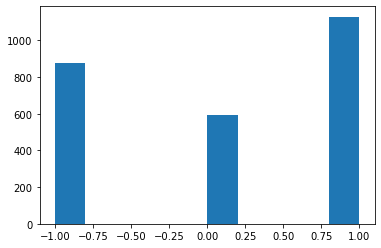

6
Centroids:  [136.86956906  25.2110127   16.40656222]
-1.0


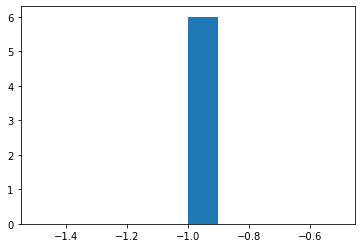

53
Centroids:  [40.64939427  4.5987618   5.10636519]
-1.0


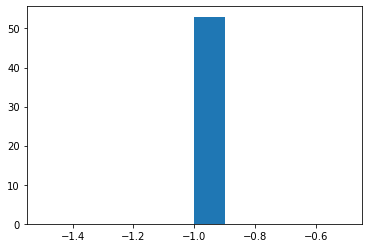

208
Centroids:  [ 4.33031236  3.26171101 15.38300437]
0.9759615384615384


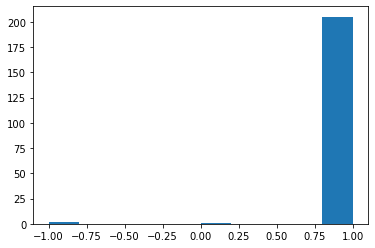

7
Centroids:  [23.75150403 99.95055084 13.86013408]
0.0


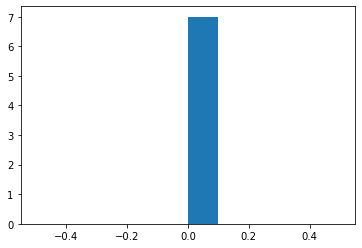

354
Centroids:  [13.29841009  1.85235879  2.43514112]
-0.8785310734463276


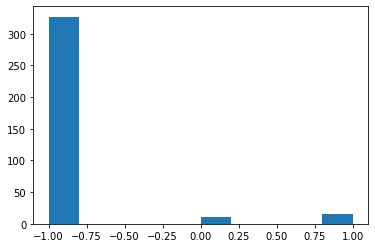

1
Centroids:  [ 33.55717084  40.2036083  164.04908477]
1.0


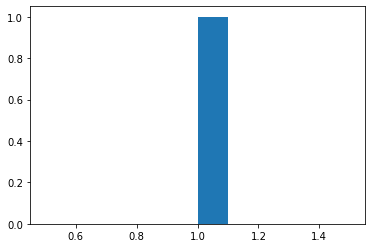

20
Centroids:  [11.6687435  11.13137405 54.29235668]
1.0


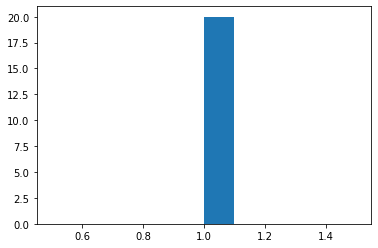

2
Centroids:  [265.40964004  14.0712629   13.61697383]
-1.0


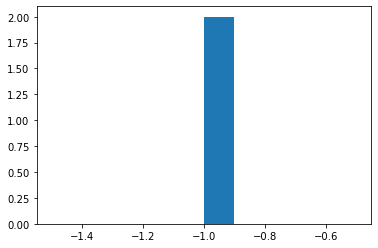

83
Centroids:  [ 5.72336194 19.57527289  4.74053404]
-0.0963855421686747


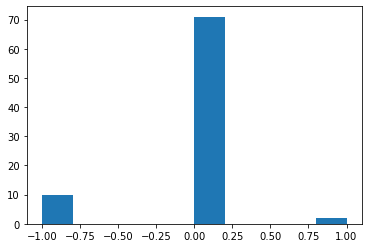

In [67]:
for i in range(n_clusters):
    print(np.sum(y_pred_train == i))
    print("Centroids: ", centroids[i])
    avg_score = np.mean(df['Sentiment'].loc[y_pred_train == i].values)
    print(avg_score)
    plt.hist(df.loc[y_pred_train == i]['Sentiment'])
    plt.show()


In [68]:
centroid_sentiments = centroids.argmax(axis=1)-1

In [69]:
sents = {'negative': 0, 'neutral': 1, 'positive': 2}

In [70]:
sentiment_mapping = dict(zip(np.unique(kmeans.labels_),centroid_sentiments))

In [71]:
y_pred = pd.Series(y_pred_train).map(sentiment_mapping).values

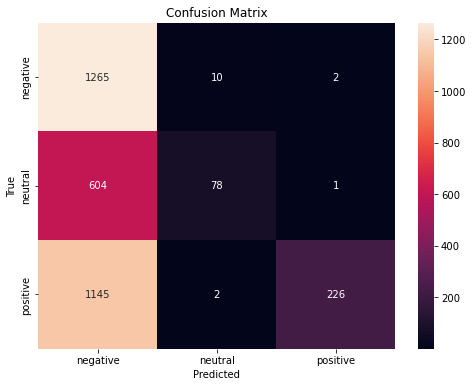

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot the confusion matrix
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sents.keys(), yticklabels=sents.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()